The sticky air method is a good way to simulate a free surface for Eulerian approaches, provided that its parameters are chosen carefully ($C\ll1$).

2.1.1 Isostatic timescale

$C_{isost}= \frac{3}{16\pi^{3}}(\frac{L}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


2.1.2 Stokes timescale

$C_{Stokes}= \frac{1}{16}\frac{\Delta \rho }{\rho }(\frac{h_{model}}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


This is the case2 in the reference, like fig.7 and fig.5

### Reference

- Crameri, F., Schmeling, H., Golabek, G. J., Duretz, T., Orendt, R., Buiter, S. J. H., ... & Tackley, P. J. (2012). A comparison of numerical surface topography calculations in geodynamic modelling: an evaluation of the ‘sticky air’method. Geophysical Journal International, 189(1), 38-54.

In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis

from underworld.scaling import units as u
from underworld.scaling import dimensionalise 
from underworld.scaling import non_dimensionalise as nd

import math
import numpy as np
import os

In [2]:
# build reference units
KL_meters   = 850 * u.kilometer
K_viscosity = 1e21  * u.pascal * u.second
K_density   = 3300 * u.kilogram / u.meter**3

# compute dependent scaling units 
#KT_seconds = 1000*u.kiloyear
#KM_kilograms = KT_seconds * KL_meters * K_viscosity
KM_kilograms = K_density * KL_meters**3
KT_seconds   = KM_kilograms / ( KL_meters * K_viscosity )
K_substance  = 1. * u.mole
#Kt_degrees   = 1. * u.kelvin

scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"]      = KL_meters.to_base_units()
#scaling_coefficients["[temperature]"] = Kt_degrees.to_base_units()
scaling_coefficients["[time]"]        = KT_seconds.to_base_units()
scaling_coefficients["[mass]"]        = KM_kilograms.to_base_units()

gravity = nd(10. * u.meter / u.second**2)

ymaxCoord = nd(850.* u.kilometer)
yminCoord = nd(0.* u.kilometer)
xmaxCoord = nd(2800.* u.kilometer)
xminCoord = nd(0.* u.kilometer)

In [3]:
# In the present Case 2, the relaxation time is about 15 ka 
DT = nd(5e3*u.year) #DT = nd(5e4*u.year)

maxSteps   = int(nd(4e6*u.year)/DT+1)
steps_output = int(nd(0.5e6*u.year)/DT)

xRes,yRes = 560,340
RESTART = 0

# output
#outputPath ="Crameri2012Case2_withVo_2.5ka/"
outputPath ="Crameri2012Case2_withVo_5ka/"

# search and build, if required, an output path
if uw.mpi.rank==0:
    try:
        if not os.path.exists("./"+outputPath+"/"):
            os.makedirs("./"+outputPath+'/')
    except:
        raise
        
bufsize=0
outfile = open(outputPath+'time.txt', 'wb',bufsize)

In [4]:
# build mesh and mesh variables
mesh = uw.mesh.FeMesh_Cartesian( elementType = 'Q1/dQ0', 
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = [xminCoord,yminCoord], 
                                 maxCoord    = [xmaxCoord,ymaxCoord],
                                 periodic    = [False, False])

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [5]:
# Create a swarm.
hmax =  1.0  #nd(850* u.kilometer)
hw = nd(150.* u.kilometer)
hLith = nd(100.* u.kilometer)
rPlume = nd(50.* u.kilometer)  
x0Plume = nd(1400.* u.kilometer) 
y0Plume =  nd(300.* u.kilometer)

swarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True)
swarm2 = uw.swarm.Swarm( mesh=mesh, particleEscape=True)

materialVariable   = swarm.add_variable( dataType="int", count=1 )
# if (RESTART == 1):
#         swarm.load(inputPath+"swarm"+ str(step).zfill(4)+".h5")
#         swarm2.load(inputPath+"surfaceSwarm"+ str(step).zfill(4)+".h5")
#         materialVariable.load(inputPath+"material"+ str(step).zfill(4)+".h5")

# else:
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=36 )
#swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

surfacePoints = np.zeros((5000,2))
surfacePoints[:,0] = np.linspace(xminCoord, xmaxCoord, 5000)
for index in range( len(surfacePoints[:,0]) ):
    surfacePoints[index,1] = hmax-hw

swarm2.add_particles_with_coordinates(surfacePoints)


# create pop control object
#pop_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.025, splitThreshold=0.2,particlesPerCell=36)
pop_control = uw.swarm.PopulationControl(swarm,aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,particlesPerCell=36)

In [6]:
# Allocate materials to particles
MantleIndex = 0
LithIndex   = 1
PlumeIndex = 2
AirIndex = 3

#if (RESTART == 0):
    # initialise everying to be upper mantle material
materialVariable.data[:] = MantleIndex

# change matieral index if the particle is not mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if math.sqrt((coord[0]-x0Plume)**2+(coord[1]-y0Plume)**2) < rPlume:
        materialVariable.data[index]     = PlumeIndex
    elif coord[1] > hmax-hw-hLith:
        if coord[1] < hmax-hw:
            materialVariable.data[index]     = LithIndex
        else:
            materialVariable.data[index]     = AirIndex


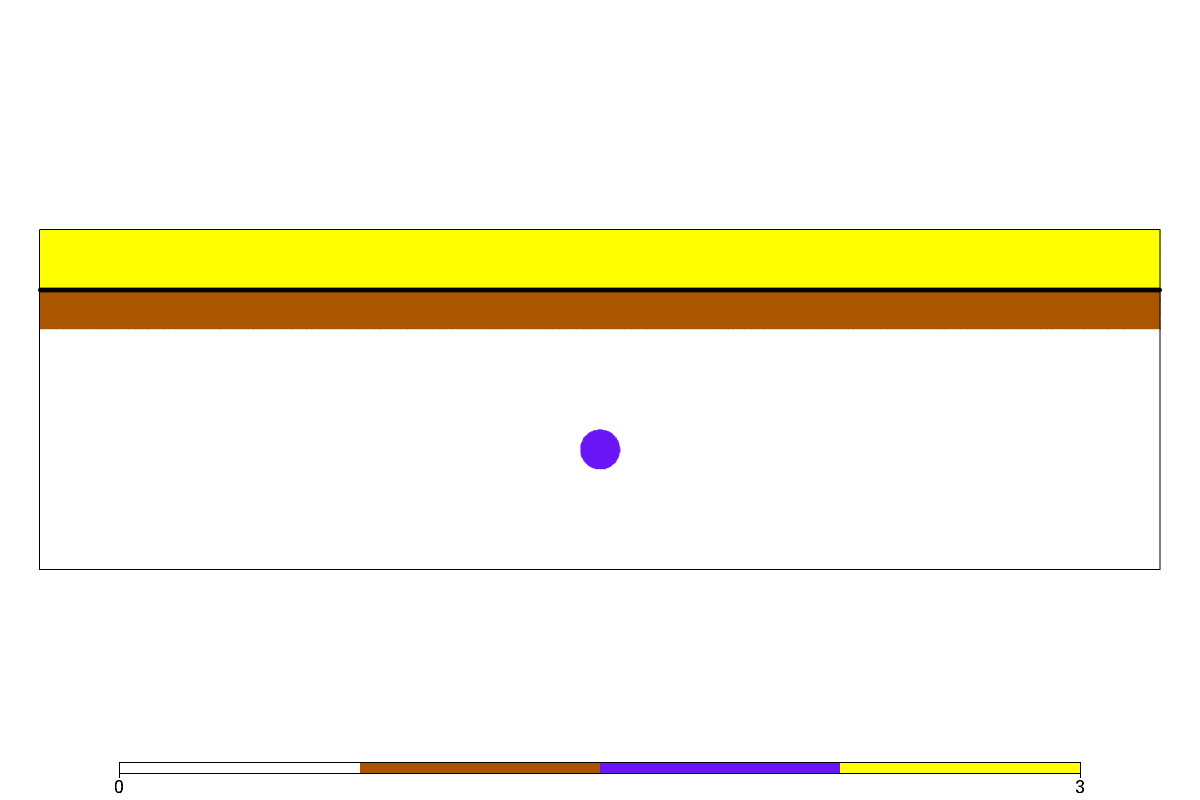

In [7]:
# Plot the initial positions for the particle swarm and colour by material type
figParticle = vis.Figure( figsize=(1200,800),quality=2)
figParticle.append (vis.objects.Points(swarm2,pointSize=5, colourBar=False))
figParticle.append( vis.objects.Points(swarm, materialVariable, pointSize=2, colours='white green red purple blue yellow',discrete=True) )
figParticle.show()

In [8]:
# **Viscosity function**
visosity_mantle = nd(1e21 * u.pascal * u.second)
visosity_plume = nd(1e20 * u.pascal * u.second)
visosity_lith = nd(1e23 * u.pascal * u.second)
visosity_air = nd(1e19 * u.pascal * u.second)


strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant( strainRateFn )

coord = fn.input()
viscosityMap = {LithIndex:visosity_lith, 
                MantleIndex:visosity_mantle, 
                PlumeIndex:visosity_plume, 
                AirIndex:visosity_air}


viscosityFn   = fn.branching.map( fn_key = materialVariable,
                                           mapping = viscosityMap )

devStressFn = 2.0 * viscosityFn * strainRateFn

In [9]:
# **Set the density function, vertical unit vector and Buoyancy Force function**
density_mantle = nd(3300. * u.kilogram / u.meter**3)
density_plume = nd(3200. * u.kilogram / u.meter**3)
density_lith = nd(3300. * u.kilogram / u.meter**3)
density_air = nd(0. * u.kilogram / u.meter**3)

densityMap = { LithIndex:density_lith,
              MantleIndex:density_mantle,
              PlumeIndex:density_plume,
              AirIndex:density_air}

densityFn = fn.branching.map( fn_key=materialVariable, mapping=densityMap ) 
# And the final buoyancy force function.
z_hat = ( 0.0, -1.0 )

buoyancyFn = densityFn * z_hat*gravity
#buoyancyFn = ( 0.0, -1.0 )

# figbuoyancy = glucifer.Figure( figsize=(1200,800),quality=2)
# figbuoyancy.append( glucifer.objects.Points(swarm, densityFn, pointSize=3.0, valueRange=None,
#                                                      colours="red yellow blue", logScale=False) )
# figbuoyancy.show()

In [10]:
# **Set initial and boundary conditions**

leftrightWalls = mesh.specialSets['Left_VertexSet'] + mesh.specialSets['Right_VertexSet']
topWalls  = mesh.specialSets[ 'Top_VertexSet'] 

bottWalls = mesh.specialSets['Bottom_VertexSet']
VelBC = uw.conditions.DirichletCondition(velocityField, (leftrightWalls+bottWalls,topWalls+bottWalls))

In [11]:
# **System and solver Setup**

stokes = uw.systems.Stokes(    velocityField = velocityField,
                               pressureField = pressureField,
                               voronoi_swarm = swarm,
                               conditions    = VelBC,
                               fn_viscosity  = viscosityFn,
                               fn_bodyforce  = buoyancyFn )


solver = uw.systems.Solver(stokes)

# "mumps" is a good alternative for "lu" but 
# not every petsc installation has mumps !
# It also works fine in parallel
# if LargePenalty == 1:
#     solver.set_penalty(1.0e6)
#     solver.set_inner_method("mumps")
#     # use "lu" direct solve and large penalty (if running in serial)
#     #if(uw.nProcs()==1):
#     #    solver.set_inner_method("lu")
# else:
#     solver.set_penalty(1.0e2)
#     solver.set_inner_method("mg")
#     solver.options.mg.levels = 6
#solver.options.scr.ksp_rtol=1.0e-8

# Optional solver settings
# if(uw.mpi.size==1):
solver.set_inner_method("lu")
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5
solver.set_inner_rtol(stokes_inner_tol) 
solver.set_outer_rtol(stokes_outer_tol) 
solver.set_penalty(0.0)

#solver.set_penalty(1.0e6)

# solver.set_penalty(1.0e6)
# solver.set_inner_method("mumps")
# solver.options.scr.ksp_rtol=1.0e-8
    
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
advector2 = uw.systems.SwarmAdvector( swarm=swarm2, velocityField=velocityField, order=2 )

In [12]:
# **Main simulation loop**
# define an update function

meshFileHandle = mesh.save(outputPath+"Mesh.h5")

def update():
    # Retrieve the maximum possible timestep for the advection system.
    #uw.barrier()
    dt1 = advector.get_max_dt()
    dt = DT
    # Advect using this timestep size.
    advector.integrate(dt,update_owners=True)
    advector2.integrate(dt,update_owners=True)

    # particle population control
    #if (step%5 ==0):
    pop_control.repopulate()
    #uw.barrier()

    if (step%steps_output ==0):
        mHnd=mesh.save(outputPath+"mesh"+ str(step).zfill(4)+".h5")
        #s1Hnd=swarm.save(outputPath+"swarm"+ str(step).zfill(4)+".h5")
        swarm2.save(outputPath+"surfaceSwarm"+ str(step).zfill(4)+".h5")
        matHnd=materialVariable.save(outputPath+"material"+ str(step).zfill(4)+".h5")        
         
        filename = outputPath+"velocityField."+str(step).zfill(4)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = outputPath+"pressureField."+str(step).zfill(4)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        outputFilename = outputPath+"image"+str(step).zfill(4)
        figParticle.save_image(outputFilename)
        
    return dt, time+dt, step+1

In [13]:
# add velocity BC for stokes solver
dtStep=0.0
step = 0
time = 0.0
while step < maxSteps:
    # Solve non linear Stokes system
    #solver.solve(nonLinearIterate=True,nonLinearMaxIterations=200,nonLinearTolerance=0.003)
    solver.solve(nonLinearIterate=False)
    solver.print_stats()


    # output figure to file at intervals = steps_output
    #if uw.rank()==0:
    print('step = {0:6d}; time = {1:.3e}; dt = {1:.3e}'.format(step,dimensionalise(time, u.kiloyear),dimensionalise(dtStep, u.kiloyear)))
    string = "{0}; {1:.3e}; {1:.3e}\n".format(step,dimensionalise(time, u.kiloyear).m,dimensionalise(dtStep, u.kiloyear).m)
    outfile.write(string.encode())
    # update
    dtStep,time,step = update()


 
Pressure iterations:  16
Velocity iterations:   1 (presolve)      
Velocity iterations:  16 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  18 (total solve)   
 
SCR RHS  setup time: 1.3806e+01
SCR RHS  solve time: 8.4392e-02
Pressure setup time: 2.6801e-02
Pressure solve time: 1.8029e+00
Velocity setup time: 5.9300e-07 (backsolve)
Velocity solve time: 1.0356e-01 (backsolve)
Total solve time   : 1.5940e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =      0; time = 0.000e+00 kiloyear; dt = 0.000e+00 kiloyear

 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 1.3424e+01
SCR RHS  solve time: 8.4328e-02
Pressure setup time: 2.4299e-02
Pressure solve time: 6.7250e+00
Velocity setup time: 9.8900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  37
Velocity iterations:   1 (presolve)      
Velocity iterations:  38 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  40 (total solve)   
 
SCR RHS  setup time: 1.3561e+01
SCR RHS  solve time: 8.3279e-02
Pressure setup time: 2.6078e-02
Pressure solve time: 4.3425e+00
Velocity setup time: 7.2800e-07 (backsolve)
Velocity solve time: 1.0238e-01 (backsolve)
Total solve time   : 1.8233e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     14; time = 7.000e+01 kiloyear; dt = 7.000e+01 kiloyear

 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.3271e+01
SCR RHS  solve time: 8.3214e-02
Pressure setup time: 2.5516e-02
Pressure solve time: 4.2017e+00
Velocity setup time: 6.2000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.3409e+01
SCR RHS  solve time: 8.2873e-02
Pressure setup time: 2.5810e-02
Pressure solve time: 3.3173e+00
Velocity setup time: 6.9500e-07 (backsolve)
Velocity solve time: 1.0224e-01 (backsolve)
Total solve time   : 1.7044e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     28; time = 1.400e+02 kiloyear; dt = 1.400e+02 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.3388e+01
SCR RHS  solve time: 8.2910e-02
Pressure setup time: 2.6101e-02
Pressure solve time: 3.3154e+00
Velocity setup time: 7.4300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3441e+01
SCR RHS  solve time: 8.3690e-02
Pressure setup time: 2.5803e-02
Pressure solve time: 3.1982e+00
Velocity setup time: 8.8900e-07 (backsolve)
Velocity solve time: 1.0190e-01 (backsolve)
Total solve time   : 1.6957e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     42; time = 2.100e+02 kiloyear; dt = 2.100e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3426e+01
SCR RHS  solve time: 8.2406e-02
Pressure setup time: 2.6034e-02
Pressure solve time: 3.2512e+00
Velocity setup time: 7.9400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3598e+01
SCR RHS  solve time: 8.3408e-02
Pressure setup time: 2.6800e-02
Pressure solve time: 3.0950e+00
Velocity setup time: 1.1270e-06 (backsolve)
Velocity solve time: 1.0244e-01 (backsolve)
Total solve time   : 1.7015e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     56; time = 2.800e+02 kiloyear; dt = 2.800e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3605e+01
SCR RHS  solve time: 8.3186e-02
Pressure setup time: 2.6501e-02
Pressure solve time: 3.1083e+00
Velocity setup time: 1.3240e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3515e+01
SCR RHS  solve time: 8.2948e-02
Pressure setup time: 2.6085e-02
Pressure solve time: 3.0802e+00
Velocity setup time: 5.8300e-07 (backsolve)
Velocity solve time: 1.0156e-01 (backsolve)
Total solve time   : 1.6913e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     70; time = 3.500e+02 kiloyear; dt = 3.500e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3428e+01
SCR RHS  solve time: 8.3691e-02
Pressure setup time: 2.6666e-02
Pressure solve time: 3.1223e+00
Velocity setup time: 6.8400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3369e+01
SCR RHS  solve time: 8.3145e-02
Pressure setup time: 2.6447e-02
Pressure solve time: 2.9640e+00
Velocity setup time: 4.7500e-07 (backsolve)
Velocity solve time: 1.0166e-01 (backsolve)
Total solve time   : 1.6651e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     84; time = 4.200e+02 kiloyear; dt = 4.200e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3455e+01
SCR RHS  solve time: 8.3222e-02
Pressure setup time: 2.6279e-02
Pressure solve time: 2.9693e+00
Velocity setup time: 6.6800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3629e+01
SCR RHS  solve time: 8.3504e-02
Pressure setup time: 2.7030e-02
Pressure solve time: 3.1212e+00
Velocity setup time: 6.8400e-07 (backsolve)
Velocity solve time: 1.0228e-01 (backsolve)
Total solve time   : 1.7073e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     98; time = 4.900e+02 kiloyear; dt = 4.900e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3663e+01
SCR RHS  solve time: 8.3153e-02
Pressure setup time: 2.7047e-02
Pressure solve time: 3.0990e+00
Velocity setup time: 6.1100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3457e+01
SCR RHS  solve time: 8.2913e-02
Pressure setup time: 1.5601e-02
Pressure solve time: 3.2026e+00
Velocity setup time: 7.0300e-07 (backsolve)
Velocity solve time: 1.0215e-01 (backsolve)
Total solve time   : 1.6966e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    112; time = 5.600e+02 kiloyear; dt = 5.600e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3413e+01
SCR RHS  solve time: 8.2988e-02
Pressure setup time: 1.5699e-02
Pressure solve time: 3.2270e+00
Velocity setup time: 8.3100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.3439e+01
SCR RHS  solve time: 8.3631e-02
Pressure setup time: 1.5531e-02
Pressure solve time: 3.3171e+00
Velocity setup time: 5.9300e-07 (backsolve)
Velocity solve time: 1.0207e-01 (backsolve)
Total solve time   : 1.7063e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    126; time = 6.300e+02 kiloyear; dt = 6.300e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3542e+01
SCR RHS  solve time: 8.2815e-02
Pressure setup time: 1.5523e-02
Pressure solve time: 3.2022e+00
Velocity setup time: 1.0700e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3884e+01
SCR RHS  solve time: 8.3274e-02
Pressure setup time: 1.5879e-02
Pressure solve time: 3.2224e+00
Velocity setup time: 6.1500e-07 (backsolve)
Velocity solve time: 1.0264e-01 (backsolve)
Total solve time   : 1.7421e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    140; time = 7.000e+02 kiloyear; dt = 7.000e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3455e+01
SCR RHS  solve time: 8.2594e-02
Pressure setup time: 1.5688e-02
Pressure solve time: 3.2002e+00
Velocity setup time: 6.3000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3649e+01
SCR RHS  solve time: 8.3232e-02
Pressure setup time: 1.5880e-02
Pressure solve time: 3.0315e+00
Velocity setup time: 5.6600e-07 (backsolve)
Velocity solve time: 1.0244e-01 (backsolve)
Total solve time   : 1.6990e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    154; time = 7.700e+02 kiloyear; dt = 7.700e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3578e+01
SCR RHS  solve time: 8.3403e-02
Pressure setup time: 1.6209e-02
Pressure solve time: 3.2062e+00
Velocity setup time: 5.6700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3419e+01
SCR RHS  solve time: 8.3450e-02
Pressure setup time: 1.5662e-02
Pressure solve time: 2.9691e+00
Velocity setup time: 6.9500e-07 (backsolve)
Velocity solve time: 1.0199e-01 (backsolve)
Total solve time   : 1.6695e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    168; time = 8.400e+02 kiloyear; dt = 8.400e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3417e+01
SCR RHS  solve time: 8.2912e-02
Pressure setup time: 1.6013e-02
Pressure solve time: 2.9660e+00
Velocity setup time: 5.9700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3296e+01
SCR RHS  solve time: 8.2599e-02
Pressure setup time: 1.5529e-02
Pressure solve time: 2.9576e+00
Velocity setup time: 4.3200e-07 (backsolve)
Velocity solve time: 1.0168e-01 (backsolve)
Total solve time   : 1.6560e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    182; time = 9.100e+02 kiloyear; dt = 9.100e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3519e+01
SCR RHS  solve time: 8.2587e-02
Pressure setup time: 1.5813e-02
Pressure solve time: 2.9588e+00
Velocity setup time: 5.6400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3330e+01
SCR RHS  solve time: 8.2661e-02
Pressure setup time: 1.5447e-02
Pressure solve time: 3.0671e+00
Velocity setup time: 7.5500e-07 (backsolve)
Velocity solve time: 1.0165e-01 (backsolve)
Total solve time   : 1.6702e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    196; time = 9.800e+02 kiloyear; dt = 9.800e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3272e+01
SCR RHS  solve time: 8.2930e-02
Pressure setup time: 1.5330e-02
Pressure solve time: 3.0763e+00
Velocity setup time: 8.0100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3440e+01
SCR RHS  solve time: 8.5914e-02
Pressure setup time: 1.5634e-02
Pressure solve time: 3.0568e+00
Velocity setup time: 1.0190e-06 (backsolve)
Velocity solve time: 1.0171e-01 (backsolve)
Total solve time   : 1.6802e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    210; time = 1.050e+03 kiloyear; dt = 1.050e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3418e+01
SCR RHS  solve time: 8.2892e-02
Pressure setup time: 1.5413e-02
Pressure solve time: 2.9353e+00
Velocity setup time: 6.5300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3202e+01
SCR RHS  solve time: 8.2673e-02
Pressure setup time: 1.5330e-02
Pressure solve time: 2.9165e+00
Velocity setup time: 6.2700e-07 (backsolve)
Velocity solve time: 1.0108e-01 (backsolve)
Total solve time   : 1.6418e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    224; time = 1.120e+03 kiloyear; dt = 1.120e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3164e+01
SCR RHS  solve time: 8.2646e-02
Pressure setup time: 1.5237e-02
Pressure solve time: 2.9756e+00
Velocity setup time: 5.4800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3129e+01
SCR RHS  solve time: 8.2630e-02
Pressure setup time: 1.5133e-02
Pressure solve time: 2.9125e+00
Velocity setup time: 6.6300e-07 (backsolve)
Velocity solve time: 1.0119e-01 (backsolve)
Total solve time   : 1.6340e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    238; time = 1.190e+03 kiloyear; dt = 1.190e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3125e+01
SCR RHS  solve time: 8.2675e-02
Pressure setup time: 1.5159e-02
Pressure solve time: 2.9718e+00
Velocity setup time: 5.2500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3148e+01
SCR RHS  solve time: 8.2611e-02
Pressure setup time: 1.5165e-02
Pressure solve time: 2.9109e+00
Velocity setup time: 7.6900e-07 (backsolve)
Velocity solve time: 1.0111e-01 (backsolve)
Total solve time   : 1.6358e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    252; time = 1.260e+03 kiloyear; dt = 1.260e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3162e+01
SCR RHS  solve time: 8.2704e-02
Pressure setup time: 1.5227e-02
Pressure solve time: 2.9126e+00
Velocity setup time: 5.2800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3356e+01
SCR RHS  solve time: 8.2846e-02
Pressure setup time: 1.5393e-02
Pressure solve time: 3.0209e+00
Velocity setup time: 5.1300e-07 (backsolve)
Velocity solve time: 1.0123e-01 (backsolve)
Total solve time   : 1.6679e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    266; time = 1.330e+03 kiloyear; dt = 1.330e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3010e+01
SCR RHS  solve time: 8.3046e-02
Pressure setup time: 1.4992e-02
Pressure solve time: 2.9036e+00
Velocity setup time: 8.9800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3256e+01
SCR RHS  solve time: 8.2341e-02
Pressure setup time: 1.5535e-02
Pressure solve time: 2.9212e+00
Velocity setup time: 7.1200e-07 (backsolve)
Velocity solve time: 1.0094e-01 (backsolve)
Total solve time   : 1.6477e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    280; time = 1.400e+03 kiloyear; dt = 1.400e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3220e+01
SCR RHS  solve time: 8.1853e-02
Pressure setup time: 1.5446e-02
Pressure solve time: 2.9231e+00
Velocity setup time: 5.4300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3234e+01
SCR RHS  solve time: 8.7931e-02
Pressure setup time: 1.5449e-02
Pressure solve time: 2.9150e+00
Velocity setup time: 6.7000e-07 (backsolve)
Velocity solve time: 1.0090e-01 (backsolve)
Total solve time   : 1.6454e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    294; time = 1.470e+03 kiloyear; dt = 1.470e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3015e+01
SCR RHS  solve time: 8.2455e-02
Pressure setup time: 1.5079e-02
Pressure solve time: 2.9053e+00
Velocity setup time: 5.4000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3282e+01
SCR RHS  solve time: 8.2791e-02
Pressure setup time: 1.5545e-02
Pressure solve time: 2.9390e+00
Velocity setup time: 7.3200e-07 (backsolve)
Velocity solve time: 1.0374e-01 (backsolve)
Total solve time   : 1.6528e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    308; time = 1.540e+03 kiloyear; dt = 1.540e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.2951e+01
SCR RHS  solve time: 8.2303e-02
Pressure setup time: 1.5046e-02
Pressure solve time: 2.9193e+00
Velocity setup time: 4.6600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3249e+01
SCR RHS  solve time: 8.2376e-02
Pressure setup time: 1.5490e-02
Pressure solve time: 2.9335e+00
Velocity setup time: 9.7200e-07 (backsolve)
Velocity solve time: 1.0076e-01 (backsolve)
Total solve time   : 1.6485e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    322; time = 1.610e+03 kiloyear; dt = 1.610e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.2913e+01
SCR RHS  solve time: 8.2258e-02
Pressure setup time: 1.5582e-02
Pressure solve time: 2.8167e+00
Velocity setup time: 5.6300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.2972e+01
SCR RHS  solve time: 8.2962e-02
Pressure setup time: 1.5063e-02
Pressure solve time: 2.8071e+00
Velocity setup time: 5.4600e-07 (backsolve)
Velocity solve time: 1.0066e-01 (backsolve)
Total solve time   : 1.6080e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    336; time = 1.680e+03 kiloyear; dt = 1.680e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.3053e+01
SCR RHS  solve time: 8.2505e-02
Pressure setup time: 1.5114e-02
Pressure solve time: 2.8063e+00
Velocity setup time: 6.8900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.2947e+01
SCR RHS  solve time: 8.2086e-02
Pressure setup time: 1.5055e-02
Pressure solve time: 2.8077e+00
Velocity setup time: 8.9700e-07 (backsolve)
Velocity solve time: 1.0063e-01 (backsolve)
Total solve time   : 1.6056e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    350; time = 1.750e+03 kiloyear; dt = 1.750e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2976e+01
SCR RHS  solve time: 8.1949e-02
Pressure setup time: 1.5206e-02
Pressure solve time: 2.7142e+00
Velocity setup time: 7.3600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.3299e+01
SCR RHS  solve time: 8.2692e-02
Pressure setup time: 1.5355e-02
Pressure solve time: 2.8196e+00
Velocity setup time: 5.1100e-07 (backsolve)
Velocity solve time: 1.0071e-01 (backsolve)
Total solve time   : 1.6422e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    364; time = 1.820e+03 kiloyear; dt = 1.820e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2931e+01
SCR RHS  solve time: 8.1870e-02
Pressure setup time: 1.5286e-02
Pressure solve time: 2.6850e+00
Velocity setup time: 1.1020e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2920e+01
SCR RHS  solve time: 8.1563e-02
Pressure setup time: 1.5162e-02
Pressure solve time: 2.6842e+00
Velocity setup time: 8.6300e-07 (backsolve)
Velocity solve time: 1.0031e-01 (backsolve)
Total solve time   : 1.5907e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    378; time = 1.890e+03 kiloyear; dt = 1.890e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2936e+01
SCR RHS  solve time: 8.2193e-02
Pressure setup time: 1.5067e-02
Pressure solve time: 2.6908e+00
Velocity setup time: 5.1700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3146e+01
SCR RHS  solve time: 8.2705e-02
Pressure setup time: 1.5463e-02
Pressure solve time: 2.6981e+00
Velocity setup time: 7.0800e-07 (backsolve)
Velocity solve time: 1.0092e-01 (backsolve)
Total solve time   : 1.6147e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    392; time = 1.960e+03 kiloyear; dt = 1.960e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3177e+01
SCR RHS  solve time: 8.1914e-02
Pressure setup time: 1.5383e-02
Pressure solve time: 2.7428e+00
Velocity setup time: 8.7800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3446e+01
SCR RHS  solve time: 8.2981e-02
Pressure setup time: 1.5220e-02
Pressure solve time: 2.6894e+00
Velocity setup time: 5.4800e-07 (backsolve)
Velocity solve time: 1.0133e-01 (backsolve)
Total solve time   : 1.6437e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    406; time = 2.030e+03 kiloyear; dt = 2.030e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3165e+01
SCR RHS  solve time: 8.3001e-02
Pressure setup time: 1.5287e-02
Pressure solve time: 2.6794e+00
Velocity setup time: 1.1410e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3142e+01
SCR RHS  solve time: 8.2328e-02
Pressure setup time: 1.5203e-02
Pressure solve time: 2.6759e+00
Velocity setup time: 6.9500e-07 (backsolve)
Velocity solve time: 1.0040e-01 (backsolve)
Total solve time   : 1.6116e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    420; time = 2.100e+03 kiloyear; dt = 2.100e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2809e+01
SCR RHS  solve time: 8.2352e-02
Pressure setup time: 1.4799e-02
Pressure solve time: 2.6590e+00
Velocity setup time: 5.9500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2891e+01
SCR RHS  solve time: 8.2520e-02
Pressure setup time: 1.4928e-02
Pressure solve time: 2.6719e+00
Velocity setup time: 5.2800e-07 (backsolve)
Velocity solve time: 1.0062e-01 (backsolve)
Total solve time   : 1.5860e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    434; time = 2.170e+03 kiloyear; dt = 2.170e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3157e+01
SCR RHS  solve time: 8.2639e-02
Pressure setup time: 1.5285e-02
Pressure solve time: 2.6935e+00
Velocity setup time: 7.3600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3096e+01
SCR RHS  solve time: 8.2587e-02
Pressure setup time: 1.5227e-02
Pressure solve time: 2.6729e+00
Velocity setup time: 6.2500e-07 (backsolve)
Velocity solve time: 1.0041e-01 (backsolve)
Total solve time   : 1.6068e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    448; time = 2.240e+03 kiloyear; dt = 2.240e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3206e+01
SCR RHS  solve time: 8.2105e-02
Pressure setup time: 1.5191e-02
Pressure solve time: 2.6732e+00
Velocity setup time: 4.2700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2899e+01
SCR RHS  solve time: 8.1932e-02
Pressure setup time: 1.4862e-02
Pressure solve time: 2.6584e+00
Velocity setup time: 5.1200e-07 (backsolve)
Velocity solve time: 1.0040e-01 (backsolve)
Total solve time   : 1.5853e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    462; time = 2.310e+03 kiloyear; dt = 2.310e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3134e+01
SCR RHS  solve time: 8.2158e-02
Pressure setup time: 1.5124e-02
Pressure solve time: 2.6760e+00
Velocity setup time: 4.2700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3131e+01
SCR RHS  solve time: 1.1662e-01
Pressure setup time: 1.5448e-02
Pressure solve time: 2.6733e+00
Velocity setup time: 9.5500e-07 (backsolve)
Velocity solve time: 1.0061e-01 (backsolve)
Total solve time   : 1.6140e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    476; time = 2.380e+03 kiloyear; dt = 2.380e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2866e+01
SCR RHS  solve time: 8.2250e-02
Pressure setup time: 1.4810e-02
Pressure solve time: 2.6605e+00
Velocity setup time: 9.6300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.2990e+01
SCR RHS  solve time: 8.2424e-02
Pressure setup time: 1.4872e-02
Pressure solve time: 2.7758e+00
Velocity setup time: 5.9100e-07 (backsolve)
Velocity solve time: 1.0039e-01 (backsolve)
Total solve time   : 1.6063e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    490; time = 2.450e+03 kiloyear; dt = 2.450e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.2844e+01
SCR RHS  solve time: 8.1528e-02
Pressure setup time: 1.5026e-02
Pressure solve time: 2.7754e+00
Velocity setup time: 4.2000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3256e+01
SCR RHS  solve time: 8.2809e-02
Pressure setup time: 1.5135e-02
Pressure solve time: 2.6723e+00
Velocity setup time: 5.2700e-07 (backsolve)
Velocity solve time: 1.0048e-01 (backsolve)
Total solve time   : 1.6228e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    504; time = 2.520e+03 kiloyear; dt = 2.520e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3107e+01
SCR RHS  solve time: 8.2039e-02
Pressure setup time: 1.5099e-02
Pressure solve time: 2.6871e+00
Velocity setup time: 7.0000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2846e+01
SCR RHS  solve time: 8.2868e-02
Pressure setup time: 1.4774e-02
Pressure solve time: 2.6576e+00
Velocity setup time: 6.0900e-07 (backsolve)
Velocity solve time: 1.0009e-01 (backsolve)
Total solve time   : 1.5800e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    518; time = 2.590e+03 kiloyear; dt = 2.590e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2904e+01
SCR RHS  solve time: 8.2297e-02
Pressure setup time: 1.4842e-02
Pressure solve time: 2.6646e+00
Velocity setup time: 7.1300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3151e+01
SCR RHS  solve time: 1.1305e-01
Pressure setup time: 1.4993e-02
Pressure solve time: 2.7651e+00
Velocity setup time: 5.5600e-07 (backsolve)
Velocity solve time: 1.0058e-01 (backsolve)
Total solve time   : 1.6247e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    532; time = 2.660e+03 kiloyear; dt = 2.660e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3097e+01
SCR RHS  solve time: 8.2262e-02
Pressure setup time: 1.5065e-02
Pressure solve time: 2.6687e+00
Velocity setup time: 8.0400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3098e+01
SCR RHS  solve time: 8.1916e-02
Pressure setup time: 1.5114e-02
Pressure solve time: 2.4397e+00
Velocity setup time: 6.6900e-07 (backsolve)
Velocity solve time: 1.0032e-01 (backsolve)
Total solve time   : 1.5835e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    546; time = 2.730e+03 kiloyear; dt = 2.730e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.3069e+01
SCR RHS  solve time: 8.3130e-02
Pressure setup time: 1.5310e-02
Pressure solve time: 2.5546e+00
Velocity setup time: 6.2400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2783e+01
SCR RHS  solve time: 8.2171e-02
Pressure setup time: 1.4996e-02
Pressure solve time: 2.4284e+00
Velocity setup time: 5.1000e-07 (backsolve)
Velocity solve time: 1.0003e-01 (backsolve)
Total solve time   : 1.5507e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    560; time = 2.800e+03 kiloyear; dt = 2.800e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3038e+01
SCR RHS  solve time: 8.3307e-02
Pressure setup time: 1.5017e-02
Pressure solve time: 2.4414e+00
Velocity setup time: 5.5200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2859e+01
SCR RHS  solve time: 8.2440e-02
Pressure setup time: 1.4709e-02
Pressure solve time: 2.4286e+00
Velocity setup time: 9.0000e-07 (backsolve)
Velocity solve time: 1.0073e-01 (backsolve)
Total solve time   : 1.5584e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    574; time = 2.870e+03 kiloyear; dt = 2.870e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2894e+01
SCR RHS  solve time: 8.2006e-02
Pressure setup time: 1.4022e-02
Pressure solve time: 2.4652e+00
Velocity setup time: 5.0700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2845e+01
SCR RHS  solve time: 8.2399e-02
Pressure setup time: 1.4875e-02
Pressure solve time: 2.4271e+00
Velocity setup time: 6.8600e-07 (backsolve)
Velocity solve time: 1.0005e-01 (backsolve)
Total solve time   : 1.5568e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    588; time = 2.940e+03 kiloyear; dt = 2.940e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3228e+01
SCR RHS  solve time: 8.2704e-02
Pressure setup time: 1.5167e-02
Pressure solve time: 2.4406e+00
Velocity setup time: 6.4900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3065e+01
SCR RHS  solve time: 8.2624e-02
Pressure setup time: 1.5316e-02
Pressure solve time: 2.4334e+00
Velocity setup time: 1.0190e-06 (backsolve)
Velocity solve time: 1.0044e-01 (backsolve)
Total solve time   : 1.5797e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    602; time = 3.010e+03 kiloyear; dt = 3.010e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3049e+01
SCR RHS  solve time: 8.2811e-02
Pressure setup time: 1.5159e-02
Pressure solve time: 2.4324e+00
Velocity setup time: 5.6600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3095e+01
SCR RHS  solve time: 8.2150e-02
Pressure setup time: 1.5349e-02
Pressure solve time: 2.4365e+00
Velocity setup time: 7.1100e-07 (backsolve)
Velocity solve time: 1.0030e-01 (backsolve)
Total solve time   : 1.5829e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    616; time = 3.080e+03 kiloyear; dt = 3.080e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2778e+01
SCR RHS  solve time: 8.2047e-02
Pressure setup time: 1.4804e-02
Pressure solve time: 2.4190e+00
Velocity setup time: 8.2300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2929e+01
SCR RHS  solve time: 8.2134e-02
Pressure setup time: 1.4928e-02
Pressure solve time: 2.4164e+00
Velocity setup time: 4.7400e-07 (backsolve)
Velocity solve time: 1.0003e-01 (backsolve)
Total solve time   : 1.5641e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    630; time = 3.150e+03 kiloyear; dt = 3.150e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3037e+01
SCR RHS  solve time: 8.2988e-02
Pressure setup time: 1.5259e-02
Pressure solve time: 2.4282e+00
Velocity setup time: 6.0700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2822e+01
SCR RHS  solve time: 8.3443e-02
Pressure setup time: 1.5102e-02
Pressure solve time: 2.4345e+00
Velocity setup time: 6.7200e-07 (backsolve)
Velocity solve time: 1.0020e-01 (backsolve)
Total solve time   : 1.5554e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    644; time = 3.220e+03 kiloyear; dt = 3.220e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.3051e+01
SCR RHS  solve time: 8.1968e-02
Pressure setup time: 1.5182e-02
Pressure solve time: 2.5453e+00
Velocity setup time: 5.7800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3006e+01
SCR RHS  solve time: 8.2093e-02
Pressure setup time: 1.5192e-02
Pressure solve time: 2.6571e+00
Velocity setup time: 4.1900e-07 (backsolve)
Velocity solve time: 9.9869e-02 (backsolve)
Total solve time   : 1.5960e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    658; time = 3.290e+03 kiloyear; dt = 3.290e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.2946e+01
SCR RHS  solve time: 8.1896e-02
Pressure setup time: 1.5331e-02
Pressure solve time: 2.6551e+00
Velocity setup time: 7.4100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.2804e+01
SCR RHS  solve time: 8.1532e-02
Pressure setup time: 1.4886e-02
Pressure solve time: 2.5324e+00
Velocity setup time: 5.4600e-07 (backsolve)
Velocity solve time: 1.0010e-01 (backsolve)
Total solve time   : 1.5630e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    672; time = 3.360e+03 kiloyear; dt = 3.360e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.3014e+01
SCR RHS  solve time: 8.2150e-02
Pressure setup time: 1.5260e-02
Pressure solve time: 2.5436e+00
Velocity setup time: 5.9600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.3028e+01
SCR RHS  solve time: 8.2194e-02
Pressure setup time: 1.5131e-02
Pressure solve time: 2.5345e+00
Velocity setup time: 6.1300e-07 (backsolve)
Velocity solve time: 9.9747e-02 (backsolve)
Total solve time   : 1.5858e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    686; time = 3.430e+03 kiloyear; dt = 3.430e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.2899e+01
SCR RHS  solve time: 8.2878e-02
Pressure setup time: 1.4900e-02
Pressure solve time: 2.5397e+00
Velocity setup time: 8.3100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.2803e+01
SCR RHS  solve time: 8.2396e-02
Pressure setup time: 1.4806e-02
Pressure solve time: 2.7809e+00
Velocity setup time: 7.6700e-07 (backsolve)
Velocity solve time: 1.0481e-01 (backsolve)
Total solve time   : 1.5887e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    700; time = 3.500e+03 kiloyear; dt = 3.500e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.2801e+01
SCR RHS  solve time: 8.2168e-02
Pressure setup time: 1.4953e-02
Pressure solve time: 2.5518e+00
Velocity setup time: 5.5500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.2990e+01
SCR RHS  solve time: 8.2686e-02
Pressure setup time: 1.5248e-02
Pressure solve time: 2.5475e+00
Velocity setup time: 7.3900e-07 (backsolve)
Velocity solve time: 9.9914e-02 (backsolve)
Total solve time   : 1.5834e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    714; time = 3.570e+03 kiloyear; dt = 3.570e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.3134e+01
SCR RHS  solve time: 8.2653e-02
Pressure setup time: 1.5001e-02
Pressure solve time: 2.5471e+00
Velocity setup time: 7.7300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.2788e+01
SCR RHS  solve time: 8.2074e-02
Pressure setup time: 1.4875e-02
Pressure solve time: 2.5404e+00
Velocity setup time: 7.8200e-07 (backsolve)
Velocity solve time: 9.9731e-02 (backsolve)
Total solve time   : 1.5623e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    728; time = 3.640e+03 kiloyear; dt = 3.640e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.2781e+01
SCR RHS  solve time: 8.1590e-02
Pressure setup time: 1.7378e-02
Pressure solve time: 2.5394e+00
Velocity setup time: 5.8400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2995e+01
SCR RHS  solve time: 8.2447e-02
Pressure setup time: 1.5111e-02
Pressure solve time: 2.4266e+00
Velocity setup time: 6.3400e-07 (backsolve)
Velocity solve time: 9.9659e-02 (backsolve)
Total solve time   : 1.5718e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    742; time = 3.710e+03 kiloyear; dt = 3.710e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2725e+01
SCR RHS  solve time: 8.1866e-02
Pressure setup time: 1.4615e-02
Pressure solve time: 2.4212e+00
Velocity setup time: 6.3000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2826e+01
SCR RHS  solve time: 8.1945e-02
Pressure setup time: 1.4708e-02
Pressure solve time: 2.4192e+00
Velocity setup time: 5.8900e-07 (backsolve)
Velocity solve time: 9.9804e-02 (backsolve)
Total solve time   : 1.5540e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    756; time = 3.780e+03 kiloyear; dt = 3.780e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2943e+01
SCR RHS  solve time: 8.1964e-02
Pressure setup time: 1.4682e-02
Pressure solve time: 2.4146e+00
Velocity setup time: 4.4400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.2980e+01
SCR RHS  solve time: 8.2618e-02
Pressure setup time: 1.5118e-02
Pressure solve time: 2.5470e+00
Velocity setup time: 9.0500e-07 (backsolve)
Velocity solve time: 9.9610e-02 (backsolve)
Total solve time   : 1.5823e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    770; time = 3.850e+03 kiloyear; dt = 3.850e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3005e+01
SCR RHS  solve time: 8.3241e-02
Pressure setup time: 1.5120e-02
Pressure solve time: 2.4349e+00
Velocity setup time: 5.8300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2971e+01
SCR RHS  solve time: 8.2404e-02
Pressure setup time: 1.4921e-02
Pressure solve time: 2.3194e+00
Velocity setup time: 9.8600e-07 (backsolve)
Velocity solve time: 9.9876e-02 (backsolve)
Total solve time   : 1.5587e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    784; time = 3.920e+03 kiloyear; dt = 3.920e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2731e+01
SCR RHS  solve time: 8.2311e-02
Pressure setup time: 1.4667e-02
Pressure solve time: 2.3068e+00
Velocity setup time: 6.0100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2792e+01
SCR RHS  solve time: 8.2807e-02
Pressure setup time: 1.4728e-02
Pressure solve time: 2.4223e+00
Velocity setup time: 7.0500e-07 (backsolve)
Velocity solve time: 9.9701e-02 (backsolve)
Total solve time   : 1.5510e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    798; time = 3.990e+03 kiloyear; dt = 3.990e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2984e+01
SCR RHS  solve time: 8.3008e-02
Pressure setup time: 1.4980e-02
Pressure solve time: 2.4308e+00
Velocity setup time: 6.9900e-07 (backsolve)
Velocity solve 